In [1]:
import sys
sys.path.append("../../XLEMOO")

In [2]:
from XLEMOO.LEMOO import EAParams, MLParams, LEMParams, LEMOO, PastGeneration
from XLEMOO.fitness_indicators import naive_sum, must_sum_to_one, asf_wrapper, single_objective
from XLEMOO.tree_interpreter import instantiate_tree_rules, find_all_paths
from XLEMOO.problems import river_pollution_problem
from XLEMOO.plotting import plot_best_fitnesses, plot_mean_fitnesses, plot_std_fitnesses
from XLEMOO.selection import SelectNBest
from desdeo_emo.recombination import SBX_xover, BP_mutation
from desdeo_emo.selection import TournamentSelection
from desdeo_problem.testproblems import test_problem_builder
from desdeo_tools.scalarization.ASF import SimpleASF, GuessASF, StomASF, PointMethodASF
from desdeo_tools.utilities import hypervolume_indicator, epsilon_indicator_ndims, fast_non_dominated_sort_indices
from typing import List

from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree
import matplotlib.pyplot as plt
import numpy as np
from imodels import C45TreeClassifier, SlipperClassifier

## Define problem

In [67]:
n_objectives = 3
n_variables = 50
problem = test_problem_builder("DTLZ7", n_variables, n_objectives)
# problem = river_pollution_problem()

## Setting model parameters

In [82]:
nadir = np.ones(n_objectives)
ideal = np.zeros(n_objectives)
# ideal = np.array([-6.34, -3.44, -7.5, 0, 0])
# nadir = np.array([-4.75, -2.85, -0.32, 9.70, 0.35])
ref_point = np.array([0.1]*n_objectives)
fitness_fun = asf_wrapper(GuessASF(nadir), {"reference_point": ref_point})

# fitness_fun = naive_sum

lem_params = LEMParams(
    n_total_iterations=60,
    n_ea_gen_per_iter=10,
    n_ml_gen_per_iter=1,
    use_darwin=True,
    use_ml=False,
    fitness_indicator=fitness_fun,
    ml_probe = 1,
    ml_threshold = 0.999,
    darwin_probe = 5,
    darwin_threshold = 0.999
)

ea_params = EAParams(
    population_size=50,
    cross_over_op=SBX_xover(),
    mutation_op=BP_mutation(problem.get_variable_lower_bounds(), problem.get_variable_upper_bounds()),
    # selection_op=TournamentSelection(None, tournament_size=2),
    selection_op=SelectNBest(None, 50),
    population_init_design="RandomDesign"
)

ml = DecisionTreeClassifier(random_state=0)
# ml = SlipperClassifier(n_estimators=5)
ml_params = MLParams(
    H_split=0.4,
    L_split=0.4,
    ml_model=ml,
    ml_fitness=fitness_fun
)

## Setup LEMOO model

In [83]:
lemoo = LEMOO(problem, lem_params, ea_params, ml_params)

In [84]:
lemoo.run()

50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50


{'darwin_mode': 176, 'learning_mode': 0}

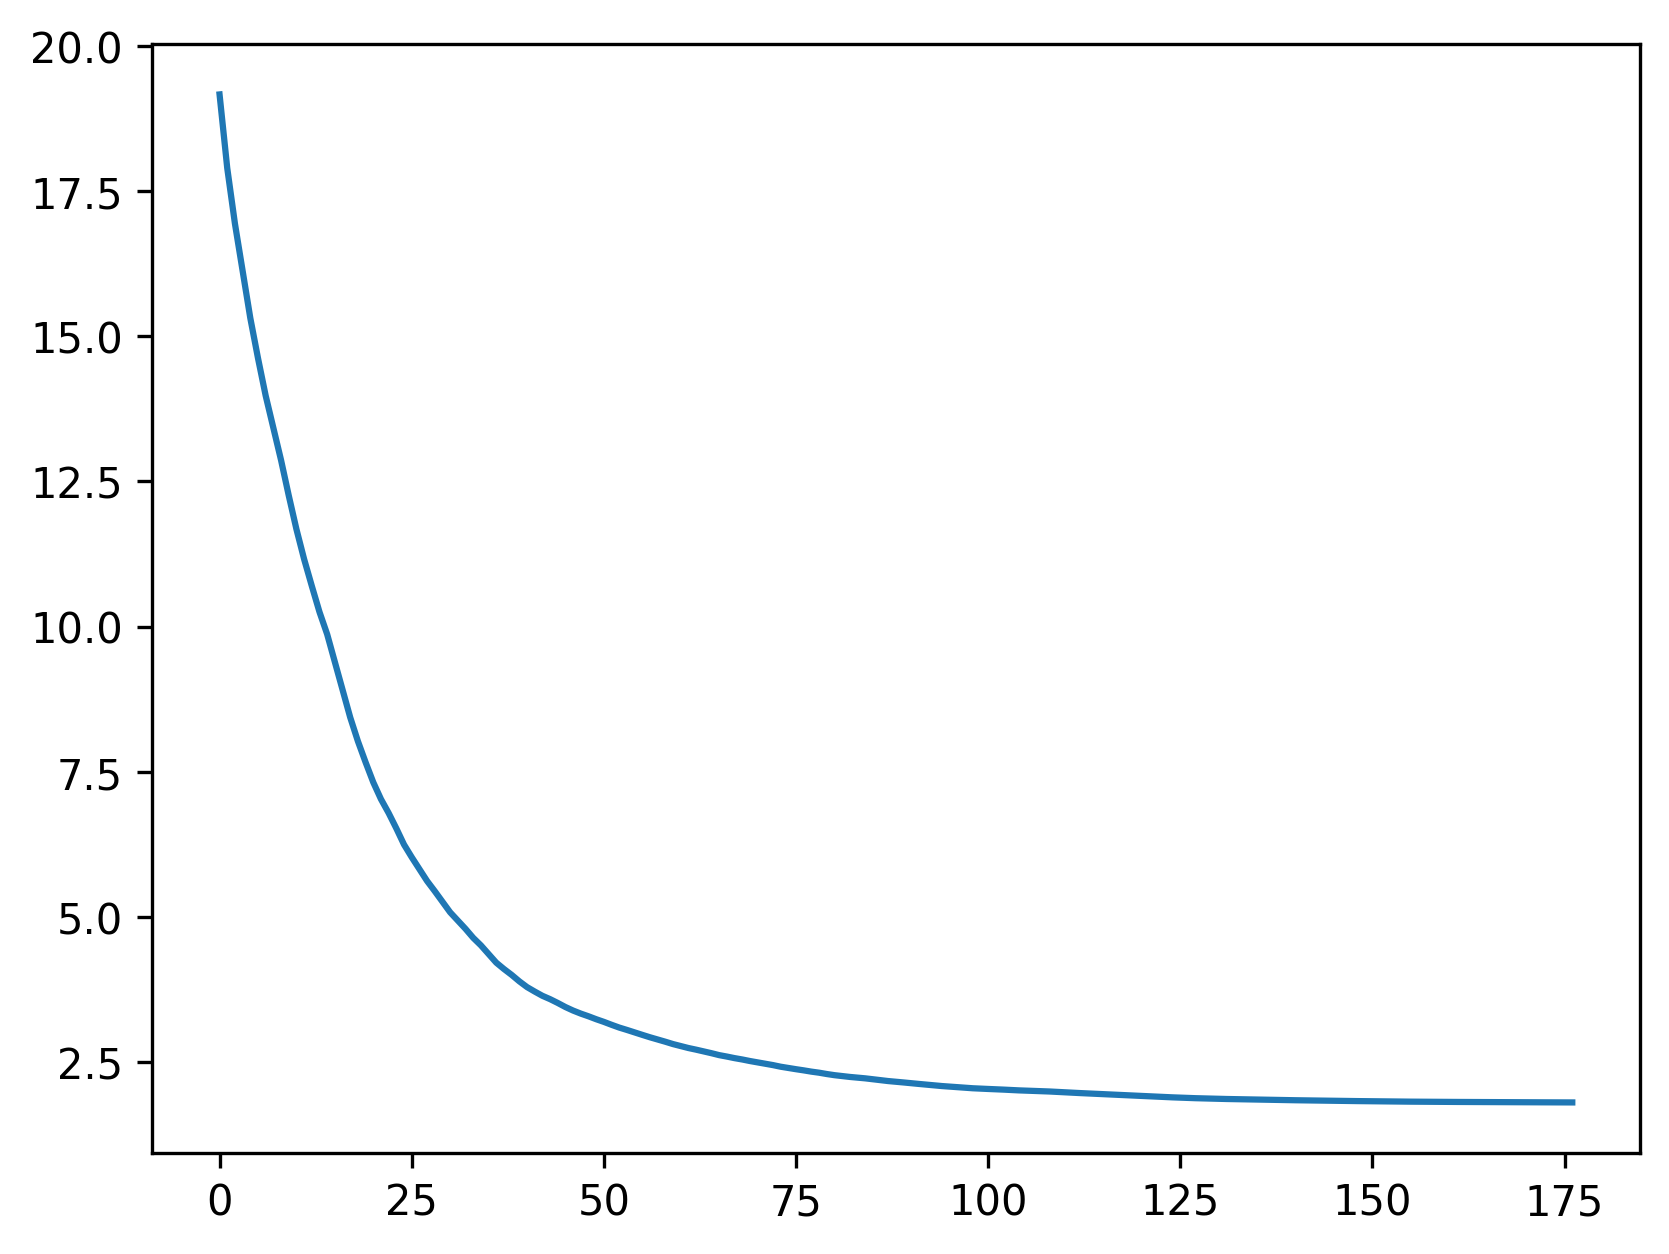

In [85]:
plot_mean_fitnesses(lemoo._generation_history)

In [20]:
#tree.plot_tree(lemoo.current_ml_model);
print(lemoo._generation_history[-1])

PastGeneration(individuals=array([[0.94352681, 0.16393057, 0.69642886, 0.32296375, 0.75845887,
        0.32937671, 0.01932923, 0.78875306, 0.72823247, 0.32857122]]), objectives_fitnesses=array([[ 0.94352681,  0.16393057, 17.65573933]]), fitness_fun_values=array([[18.76319671]]))
